## Проект: Аналитика в Яндекс.Афише

Задача: оптимизировать маркетинговые затраты

### Описание данных
#### Таблица visits (лог сервера с информацией о посещениях сайта):

- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь

#### Таблица orders (информация о заказах):

- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа

#### Таблица costs (информация о затратах на маркетинг):

- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

#### Импорт библиотек

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from time import strftime
import warnings
warnings.filterwarnings('ignore')

### <span style="color:blue"> Шаг 1: Чтение файлов и сводная информация<span>

#### Таблица visits (лог сервера с информацией о посещениях сайта)

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
visits.info()
visits.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Device,End Ts,Source Id,Start Ts,Uid
237094,touch,2018-01-22 23:27:00,2,2018-01-22 23:02:00,2575490067779792927
221974,desktop,2018-03-25 14:16:00,3,2018-03-25 14:03:00,1799172374853724068
63223,desktop,2017-12-19 15:08:00,2,2017-12-19 14:37:00,13777709499124655504
95341,desktop,2018-05-23 18:30:00,10,2018-05-23 18:26:00,12491346332934232912
885,desktop,2017-11-19 19:40:00,4,2017-11-19 19:40:00,6472699560896724620


Пропущенных значений нет.

In [3]:
# привожу название столбцов к нижнему регистру
visits.columns = visits.columns.str.lower()
visits.columns

Index(['device', 'end ts', 'source id', 'start ts', 'uid'], dtype='object')

In [4]:
# переименовываю столбцы с пробелами
visits.rename(columns={'end ts': 'end_ts','source id':'source_id', 'start ts':'start_ts'}, inplace=True)
visits.columns

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

In [5]:
# столбцы с датой и временем начала и окончания сессий привожу к формату datetime
visits['end_ts']=pd.to_datetime(visits['end_ts'], format="%Y-%m-%d %H:%M")
visits['start_ts']=pd.to_datetime(visits['start_ts'], format="%Y-%m-%d %H:%M")

In [6]:
#проверила нет ли дубликатов
visits.duplicated().sum()

0

In [7]:
# проверка
visits.info()
visits.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


,device,end_ts,source_id,start_ts,uid
73977,touch,2017-09-30 15:00:00,4,2017-09-30 14:44:00,17994542151884852083
268515,desktop,2017-11-24 14:17:00,5,2017-11-24 14:10:00,7221438857015807709
14877,desktop,2017-12-18 11:57:00,4,2017-12-18 11:56:00,10106606086678453574
150850,desktop,2017-11-26 13:50:00,4,2017-11-26 13:35:00,17056149318756072954
275928,touch,2018-03-24 16:39:00,2,2018-03-24 16:37:00,990856801996469257


Я предпполагаю, что вид девайса тут делится на ПК -device и смартфон с тачскрином - touch, поэтому я их дальше буду по-русски называть.=)

#### Таблица orders (информация о заказах)

In [8]:
orders = pd.read_csv('/datasets/orders_log.csv')
orders.info()
orders.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Buy Ts,Revenue,Uid
28183,2018-01-05 13:08:00,12.22,16719538847513460268
12801,2017-10-14 22:33:00,1.95,15509308908520572514
2939,2017-07-10 10:57:00,4.58,9951737982025533647
10923,2017-10-05 21:38:00,0.55,2355117916482869091
38482,2018-03-06 13:46:00,0.61,17238185756765694601


In [9]:
# привожу название столбцов к нижнему регистру
orders.columns = orders.columns.str.lower()
orders.columns

Index(['buy ts', 'revenue', 'uid'], dtype='object')

In [10]:
# переименовываю столбцы с пробелами
orders.rename(columns={'buy ts': 'buy_ts'}, inplace=True)
orders.columns

Index(['buy_ts', 'revenue', 'uid'], dtype='object')

In [11]:
# меняю формат на датавремя
orders['buy_ts']=pd.to_datetime(orders['buy_ts'], format="%Y-%m-%d %H:%M")

In [12]:
#проверила нет ли дубликатов
orders.duplicated().sum()

0

In [13]:
# проверка
orders.info()
orders.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


,buy_ts,revenue,uid
11400,2017-10-07 12:10:00,6.72,11847408867819900646
44652,2018-04-19 12:24:00,2.33,7513825149345462645
42780,2018-03-30 00:00:00,0.73,9132626503120023298
47708,2018-05-17 17:25:00,7.94,9281428310238207918
44709,2018-04-19 17:12:00,2.38,6971000183743566788


#### Таблица costs (информация о затратах на маркетинг)

In [14]:
costs = pd.read_csv('/datasets/costs.csv')
costs.info()
costs.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,dt,costs
2138,9,2018-04-21,9.75
1070,3,2018-05-13,271.35
2030,9,2018-01-01,27.23
1240,4,2017-10-30,309.56
1402,4,2018-04-12,160.14


In [15]:
#проверила нет ли дубликатов
costs.duplicated().sum()

0

In [16]:
costs['dt']=pd.to_datetime(costs['dt'], format="%Y-%m-%d")
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


### <span style="color:blue"> Шаг 2: Отчеты и метрики <span>

####  <span style="color: orange"> 2.1 Продукт <span>

#### Анализ количества использования Яндекс Афиши пользователями 

In [17]:
# выделяю в отдельные столбцы год, месяц, неделю и дату без времени
visits['ses_year'] = visits['start_ts'].dt.year
visits['ses_month'] = visits['start_ts'].dt.month
visits['ses_week'] = visits['start_ts'].dt.week
visits['ses_date'] = visits['start_ts'].dt.date

In [18]:
# количество уникальных пользователей в месяц
mau = visits.groupby(['ses_year', 'ses_month']).agg({'uid': 'nunique'}).mean()
int(mau)

23228

In [19]:
# количество уникальных пользователей в неделю
wau = visits.groupby(['ses_year', 'ses_week']).agg({'uid': 'nunique'}).mean()
int(wau)

5716

In [20]:
# количество уникальных пользователей в день
dau = visits.groupby(['ses_date']).agg({'uid': 'nunique'}).mean()
int(dau)

907

In [21]:
sticky_mau = dau / mau *100
sticky_mau

uid    3.90897
dtype: float64

In [22]:
sticky_wau = dau / wau *100
sticky_wau

uid    15.884409
dtype: float64

Количество уникальных пользователей довольно большое.
Но по ощущениям sticky factor не очень высок, но я не знаю какой нормальный процент для Афиши и как его правильно оценить. В Википедии, например написано, что для игр нормальным считается показатель Sticky Factor порядка 18%. 

#### Количество сессий на человека в день 

In [23]:
ses_per_user = visits.groupby(['ses_date']).agg({'uid': ['count','nunique']})
ses_per_user.columns = ['n_sessions', 'n_users']
ses_per_user['sessions_per_user'] = ses_per_user['n_sessions'] / ses_per_user['n_users']
ses_per_user

,n_sessions,n_users,sessions_per_user
ses_date,,,
2017-06-01,664,605,1.097521
2017-06-02,658,608,1.082237
2017-06-03,477,445,1.071910
2017-06-04,510,476,1.071429
2017-06-05,893,820,1.089024
...,...,...,...
2018-05-27,672,620,1.083871
2018-05-28,1156,1039,1.112608
2018-05-29,1035,948,1.091772


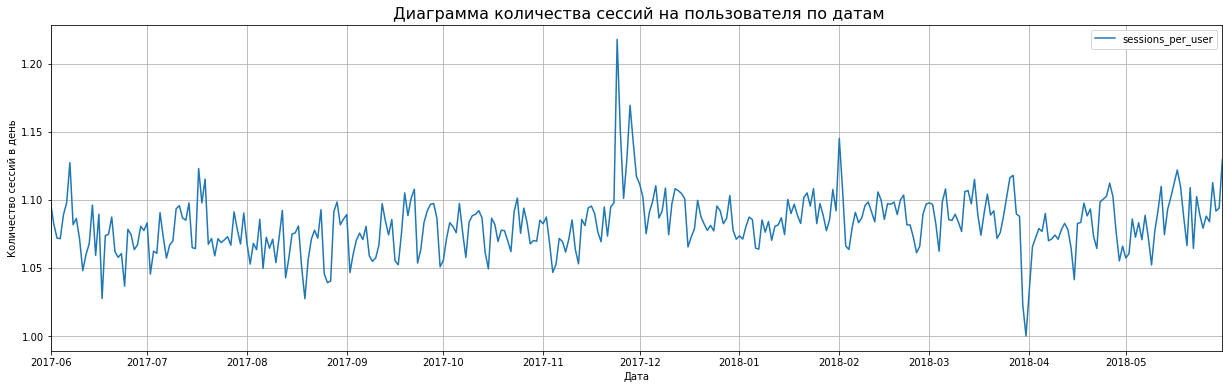

In [24]:
ses_per_user.plot(y='sessions_per_user', grid=True, figsize=(21, 6))
plt.title(' Диаграмма количества сессий на пользователя по датам', fontsize=16)
plt.xlabel("Дата")
plt.ylabel("Количество сессий в день")
plt.show()

Вывод: 

В среднем на каждого пользователя в день приходится один сеанс. Есть всплеск активности пользователей перед новым годом, видимо закупались билетами на долгие выходные (декабрь 2017) и какой то аномальный спад в апреле 2018 года, возможно в этот день проводились технические работы на сайте и сервис был недоступен.

In [25]:
# группировка сессий по устройствам
visits.groupby(['device', 'ses_date']).agg({'uid': ['count','nunique']})

uid        
                   count nunique
device  ses_date                
desktop 2017-06-01   501     455
        2017-06-02   498     458
        2017-06-03   329     307
        2017-06-04   349     326
        2017-06-05   693     631
...                  ...     ...
touch   2018-05-27   246     236
        2018-05-28   321     303
        2018-05-29   284     263
        2018-05-30   421     393
        2018-05-31   712     655

[727 rows x 2 columns]

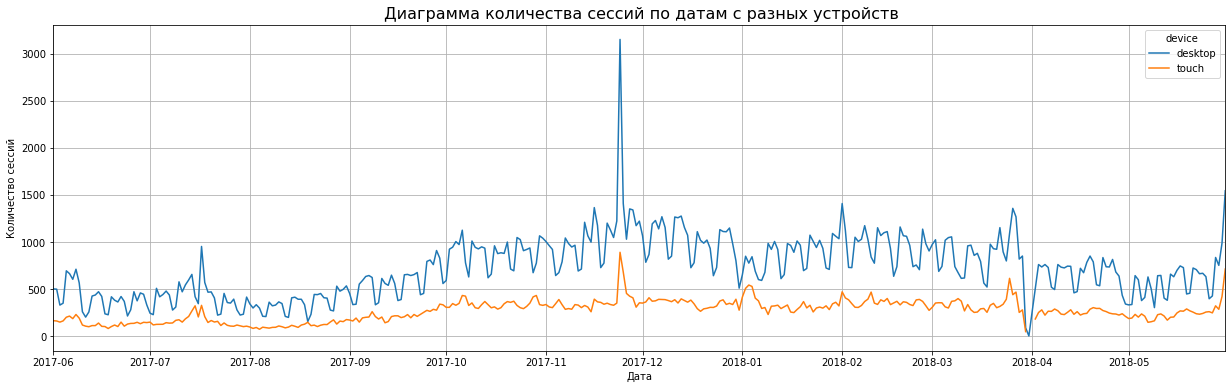

In [26]:
visits.pivot_table(index='ses_date',columns='device', values='uid', aggfunc='count').plot(grid=True, figsize=(21, 6))
plt.title(' Диаграмма количества сессий по датам c разных устройств', fontsize=16) 
plt.xlabel("Дата")
plt.ylabel("Количество сессий")
plt.show()

Пользователи предпочитают заходить на сайт с настольного ПК, чем с телефона.

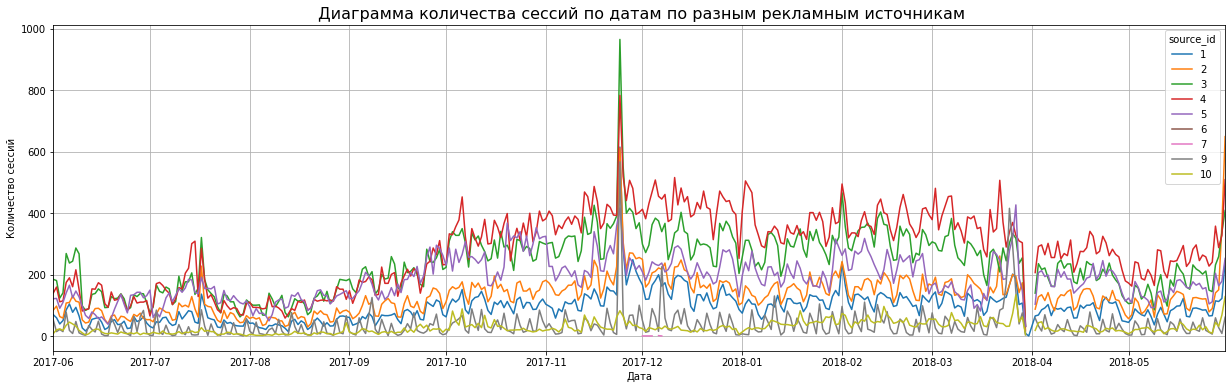

In [27]:
visits.pivot_table(index='ses_date', columns='source_id', values='uid', aggfunc='count').plot(grid=True, figsize=(21, 6))
plt.title(' Диаграмма количества сессий по датам по разным рекламным источникам', fontsize=16) 
plt.xlabel("Дата")
plt.ylabel("Количество сессий")
plt.show()

Посмотрела из каких рекламных источников больше пользовательской активноти. видно, что источник №4 после нового года стал привлекать немного больше людей, чем другие источники.

#### Анализ длительности сессий

In [28]:
# считаю длительность сессий в минутах
visits['session_duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds / 60

(0, 750)

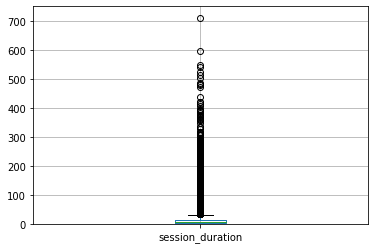

In [29]:
visits.boxplot('session_duration')
plt.ylim(0, 750)

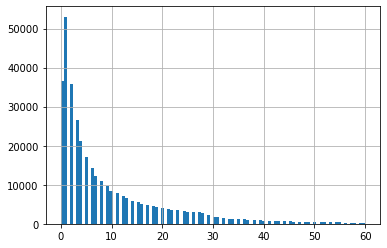

In [30]:
visits['session_duration'].hist(bins=100, range=(0, 60))
plt.show()

Посмотрела на длительность сессий с помощью boxplot, очень большой хвост. Скорее всего эти пользователи зашли в акаунт на сайте, может быть даже купили билеты, но не вышли из аккаунта, сессия длится очень долго. Также есть очень быстрые сессии.

In [31]:
visits.groupby('device')['session_duration'].agg('median')

device
desktop    6.0
touch      3.0
Name: session_duration, dtype: float64

In [32]:
# считаю моду (значение в выборке, которое встречается чаще всего
visits['session_duration'].mode()

0    1.0
dtype: float64

На мой взгляд 1 минута это мало для того чтобы сделать заказ. Если человек знает на какое мероприятие хочет конкретно, может быть он конечно и успеет купить. Но я представляю себя на месте пользователя и когда захожу выбирать билеты меньше 15 минут на сайте точно не провожу. Пока посмотришь мероприятия, пока дату выберешь, а еще надо отзывы почитать и места выбрать... Мне кажется надо проверять что здесь не так.

#### Количество возвращающихся пользователей

In [33]:
# выделяю дату первой сессии
visits['ses_date']=pd.to_datetime(visits['ses_date'])
first_ses = visits.groupby('uid')['ses_date'].min() 
first_ses.name = 'first_ses_date'

In [34]:
# присоединяю дату первой сессии к таблице visits
visits = visits.join(first_ses, on='uid')

In [35]:
# выделяю первый месяц и месяц в котором была сессия в отдельные столбцы, тк хочу сделать помесячный retention
visits['first_month'] = visits['first_ses_date'].astype('datetime64[M]')
visits['n_ses_month'] = visits['ses_date'].astype('datetime64[M]')

In [36]:
# считаю время жизни когорты
visits['cohort_lifetime'] = visits['n_ses_month'] - visits['first_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

In [37]:
# считаю для каждой когорты количество активных пользователей на определённый месяц
cohorts = visits.groupby(['first_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

In [38]:
# считаю исходное количество пользователей в когорте
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

In [39]:
cohorts = cohorts.merge(initial_users_count,on='first_month')

In [40]:
cohorts.head()

,first_month,cohort_lifetime,uid,cohort_users
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259
3,2017-06-01,3,814,13259
4,2017-06-01,4,909,13259


In [41]:
# считаю retention: количество активных пользователей к общему числу
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

In [42]:
# сводная таблица по возвращающихся пользователей
ret = cohorts.pivot_table(index='first_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
ret

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


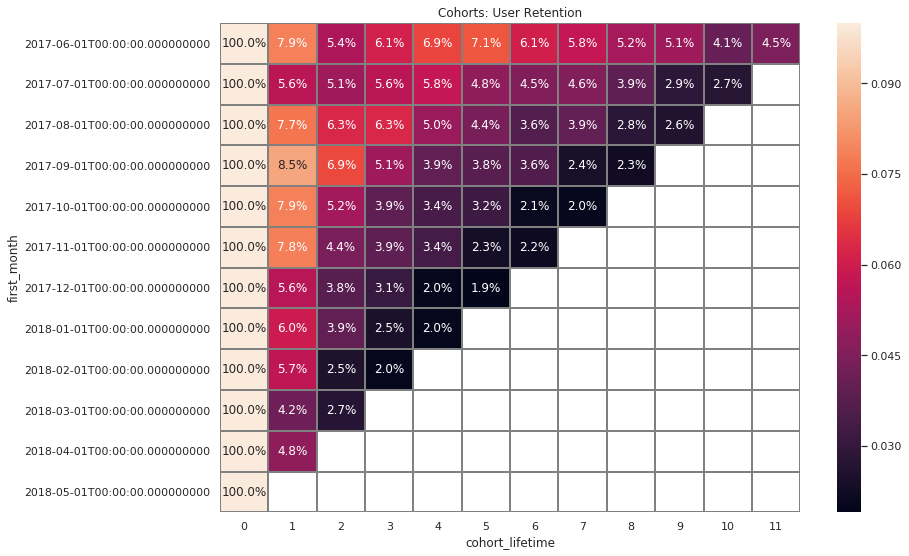

In [43]:
# строю ткпловую карту
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(ret, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmax=.1)
plt.show()

Вывод: в целом видна тенденция к спаду процентов возвращающихся пользователей. Однако в сентябре в певой когорте процент возвращающихся пользователей возрос. Также сами проценты не очень высокие, но мне кажется это нормально. Я предполагаю, что Афиша это не тот продукт, которым среднестатистический человек пользуются каждый месяц, тк не все ходят ежемесячно в театр и на концерты. Конечно, билеты в кино тоже там можно покупать, но у кинотеатров есть свои сайты и приложения. Мне, например, как пользователю, проще зайти на сайт кинотеатра который рядом с домом/работой и выбрать подходящий сеанс, чем искать его в Афише.

####  <span style="color: orange"> 2.2 Продажи <span>

#### Подсчет времени между первым посещением и первой покупкой

In [44]:
# выделяю дату и время первой покупки 
first_order = orders.sort_values(by=['uid','buy_ts']).groupby('uid').agg({'buy_ts':'first'})

In [45]:
# выделяю дату и время первой сессии
first_visit = visits.sort_values(by=['uid','start_ts']).groupby('uid').agg({'start_ts':'first', 'source_id':'first', 'device':'first'})

In [46]:
time  = first_visit.merge(first_order, on='uid')

In [47]:
# считаю разницу во времени между временем первой сессии и первым заказом
time['duration_ses_order'] = (time['buy_ts']- time['start_ts']).dt.seconds
time['duration_ses_order'] = time['duration_ses_order'] / 60
time.head()

,start_ts,source_id,device,buy_ts,duration_ses_order
uid,,,,,
313578113262317,2017-09-18 22:49:00,2,desktop,2018-01-03 21:51:00,1382.0
1575281904278712,2017-06-03 10:13:00,10,touch,2017-06-03 10:13:00,0.0
2429014661409475,2017-10-11 17:14:00,3,desktop,2017-10-11 18:33:00,79.0
2464366381792757,2018-01-27 20:10:00,5,desktop,2018-01-28 15:54:00,1184.0
2551852515556206,2017-11-24 10:14:00,5,desktop,2017-11-24 10:14:00,0.0


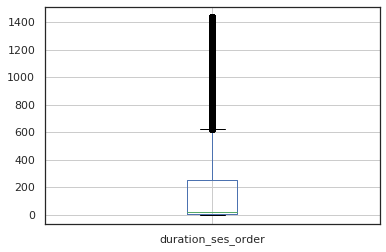

In [48]:
time.boxplot('duration_ses_order')
plt.show()

In [49]:
time =time.query('duration_ses_order > 0 and duration_ses_order < 600')

In [50]:
time['duration_ses_order'].median()

11.0

Отсекла хвост по боксплоту и посмотрела медианную длительность. Поличилось 11 минут, по моему вполне нормально время чтобы сделать заказ.

In [51]:
time.groupby('device')['duration_ses_order'].median()

device
desktop    11.0
touch      14.0
Name: duration_ses_order, dtype: float64

Можно заметить, что пользователи смартфонов тратят чуть больше времени на заказ, предполагаю что это связано с вличиной экрана, пользователям нужно пролистывать больше, чтобы найти необходимую информацию.
Было бы интересно посмотреть на время, за которое пользователь совершает покупку в приложении и сравнить его со временем на сайте, я же правильно понимаю что в этом проекте данные только с сайта?

#### Анализ покупок по месяцам

In [52]:
# дата первого заказа
first_order = orders.groupby('uid')['buy_ts'].min() 
first_order.name = 'first_order_date'

In [53]:
orders = orders.join(first_order, how='left', on=['uid'])
orders.head()

,buy_ts,revenue,uid,first_order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00


In [54]:
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

#### Сколько покупок за месяц, неделю

In [55]:
# объединяю таблицы визитов и заказов
df = pd.merge(visits, orders, how='left', on='uid')

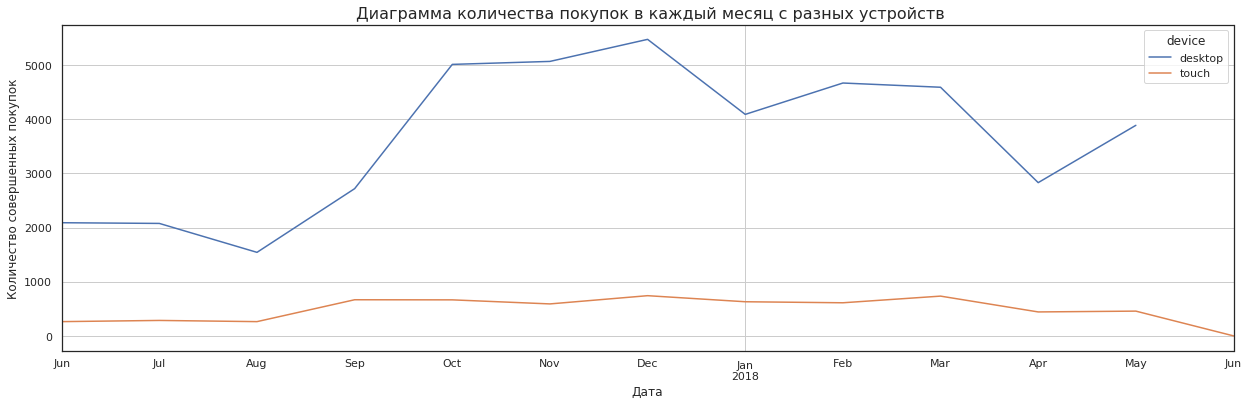

In [56]:
# количество покупок по месяцам

df['order_month'] = orders['buy_ts'].astype('datetime64[M]')
df.pivot_table(index='order_month', columns='device', values='uid', aggfunc='count').plot(grid=True, figsize=(21, 6))
plt.title(' Диаграмма количества покупок в каждый месяц с разных устройств', fontsize=16) 
plt.xlabel("Дата")
plt.ylabel("Количество совершенных покупок")
plt.show()

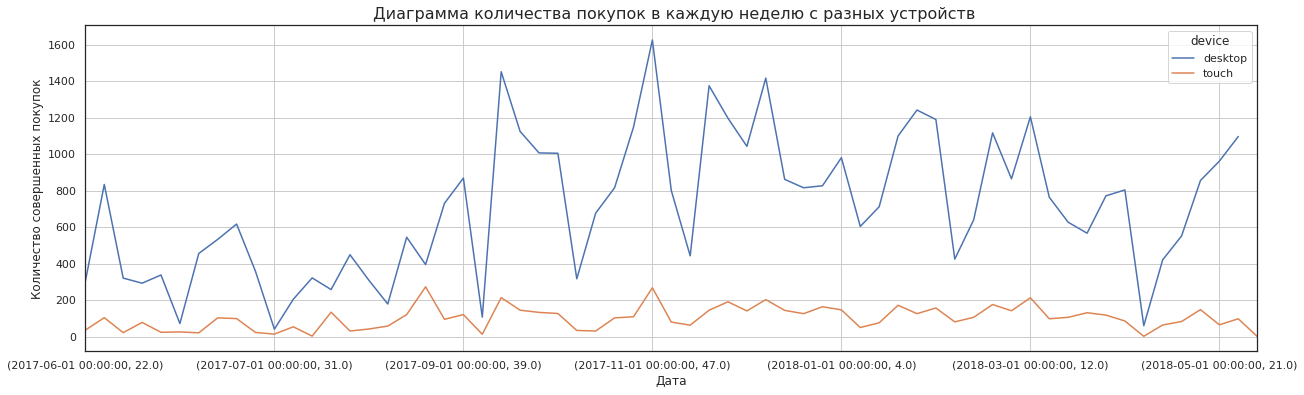

In [57]:
# количество покупок по неделям
df['order_week'] = orders['buy_ts'].dt.week

df.pivot_table(index=('order_month', 'order_week'), columns='device', values='uid', aggfunc='count').plot(grid=True, figsize=(21, 6))
plt.title(' Диаграмма количества покупок в каждую неделю с разных устройств', fontsize=16) 
plt.xlabel("Дата")
plt.ylabel("Количество совершенных покупок")

plt.show()

Пользователи предпочитают покупать с компьютера, возможно, с большого экрана удобнее выбрать места на мероприятия. Только я не поняла почему линия desctop обрывается в районе мая...

In [58]:
df.query('device=="desktop" and order_month=="2018-05-01"')

,device,end_ts,source_id,start_ts,uid,ses_year,ses_month,ses_week,ses_date,session_duration,first_ses_date,first_month,n_ses_month,cohort_lifetime,buy_ts,revenue,first_order_date,first_order_month,order_month,order_week
46068,desktop,2018-04-16 17:30:00,2,2018-04-16 17:08:00,2569181675832811876,2018,4,16,2018-04-16,22.0,2017-12-23,2017-12-01,2018-04-01,4,2017-12-29 11:33:00,1.95,2017-12-24 09:15:00,2017-12-01,2018-05-01,18.0
46069,desktop,2018-04-16 17:30:00,2,2018-04-16 17:08:00,2569181675832811876,2018,4,16,2018-04-16,22.0,2017-12-23,2017-12-01,2018-04-01,4,2017-12-30 10:26:00,1.65,2017-12-24 09:15:00,2017-12-01,2018-05-01,18.0
46070,desktop,2018-04-16 17:30:00,2,2018-04-16 17:08:00,2569181675832811876,2018,4,16,2018-04-16,22.0,2017-12-23,2017-12-01,2018-04-01,4,2018-01-02 15:52:00,4.25,2017-12-24 09:15:00,2017-12-01,2018-05-01,18.0
46071,desktop,2018-04-16 17:30:00,2,2018-04-16 17:08:00,2569181675832811876,2018,4,16,2018-04-16,22.0,2017-12-23,2017-12-01,2018-04-01,4,2018-01-05 11:26:00,2.20,2017-12-24 09:15:00,2017-12-01,2018-05-01,18.0
46072,desktop,2018-04-16 17:30:00,2,2018-04-16 17:08:00,2569181675832811876,2018,4,16,2018-04-16,22.0,2017-12-23,2017-12-01,2018-04-01,4,2018-01-05 16:07:00,1.10,2017-12-24 09:15:00,2017-12-01,2018-05-01,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50407,desktop,2018-02-27 21:07:00,2,2018-02-27 21:06:00,4724847370123575803,2018,2,9,2018-02-27,1.0,2018-02-27,2018-02-01,2018-02-01,0,NaT,NaN,NaT,NaT,2018-05-01,22.0
50408,desktop,2018-04-06 10:15:00,4,2018-04-06 10:14:00,5221548826189092291,2018,4,14,2018-04-06,1.0,2018-04-06,2018-04-01,2018-04-01,0,NaT,NaN,NaT,NaT,2018-05-01,22.0
50409,desktop,2018-03-21 14:26:00,1,2018-03-21 14:00:00,15924410637365013358,2018,3,12,2018-03-21,26.0,2018-03-21,2018-03-01,2018-03-01,0,NaT,NaN,NaT,NaT,2018-05-01,22.0
50410,desktop,2018-02-07 17:17:00,4,2018-02-07 17:17:00,11801812877851543647,2018,2,6,2018-02-07,0.0,2018-02-07,2018-02-01,2018-02-01,0,2018-02-13 16:35:00,6.67,2018-02-13 16:35:00,2018-02-01,2018-05-01,22.0


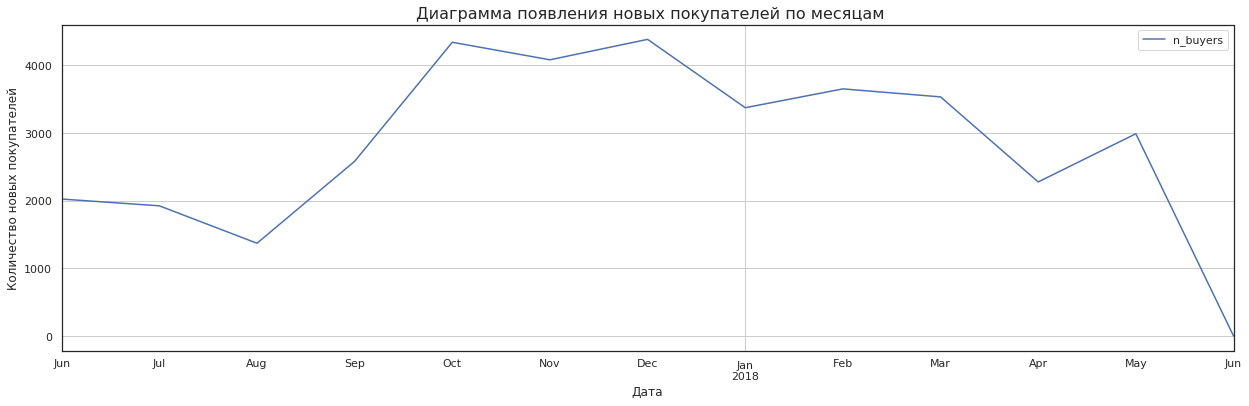

In [59]:
# количество новых покупателей (n_buyers) за каждый месяц

cohort_sizes = orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes.plot(y='n_buyers', x='first_order_month', grid=True, figsize=(21, 6))
plt.title(' Диаграмма появления новых покупателей по месяцам', fontsize=16) 
plt.xlabel("Дата")
plt.ylabel("Количество новых покупателей")

plt.show()

Из диаграммы видно, что осенью 2017 количество новых покупателей увеличилось, но после нового года пошло на спад.

#### Анализ среднего чека

In [60]:
orders_grouped_by_cohorts = orders.groupby(['first_order_month','order_month']).agg({'revenue':'sum','uid':'nunique'})

In [61]:
# прибыль и количество пользователей по месяцам
orders_grouped_by_cohorts.head()

revenue   uid
first_order_month order_month               
2017-06-01        2017-06-01   9557.49  2023
                  2017-07-01    981.82    61
                  2017-08-01    885.34    50
                  2017-09-01   1931.30    54
                  2017-10-01   2068.58    88

In [62]:
# средний чек
orders_grouped_by_cohorts['revenue_per_user'] = orders_grouped_by_cohorts['revenue'] / orders_grouped_by_cohorts['uid']

In [63]:
# сводная таблица изменения среднего чека в когортах по месяцу совершения покупки
orders_grouped_by_cohorts.pivot_table(index='first_order_month',columns='order_month',values='revenue_per_user',aggfunc='mean').style.highlight_max(axis='columns')

order_month,2017-06-01 00:00:00,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00,2018-05-01 00:00:00,2018-06-01 00:00:00
first_order_month,,,,,,,,,,,,,
2017-06-01 00:00:00,4.72441,16.0954,17.7068,35.7648,23.5066,22.2078,31.0119,25.0332,19.2957,27.2336,25.6813,9.80415,nan
2017-07-01 00:00:00,nan,6.01022,12.3963,21.036,10.7861,6.93816,7.89684,6.42111,6.99282,7.38214,12.8618,11.5138,nan
2017-08-01 00:00:00,nan,nan,5.27652,11.1488,11.8513,12.183,16.9212,12.1391,9.62033,12.6105,21.07,8.30742,nan
2017-09-01 00:00:00,nan,nan,nan,5.64453,22.1884,13.4452,138.669,19.8815,26.095,27.4371,16.9614,11.0447,nan
2017-10-01 00:00:00,nan,nan,nan,nan,5.00373,11.2874,6.75325,7.41315,7.0728,7.25514,6.57321,7.4797,nan
2017-11-01 00:00:00,nan,nan,nan,nan,nan,5.15468,7.33905,6.78658,12.5107,7.45728,4.58083,7.56484,nan
2017-12-01 00:00:00,nan,nan,nan,nan,nan,nan,4.73819,7.81658,39.366,48.1351,27.4314,23.5184,nan
2018-01-01 00:00:00,nan,nan,nan,nan,nan,nan,nan,4.13564,8.72123,12.3655,11.1998,4.69956,nan
2018-02-01 00:00:00,nan,nan,nan,nan,nan,nan,nan,nan,4.15699,8.61,4.94241,6.94103,nan


In [64]:
# lifetime когорты
orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index()
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['order_month'] - orders_grouped_by_cohorts['first_order_month']
orders_grouped_by_cohorts['cohort_lifetime'].head()

0     0 days
1    30 days
2    61 days
3    92 days
4   122 days
Name: cohort_lifetime, dtype: timedelta64[ns]

In [65]:
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'].round().astype('int')

In [66]:
orders_grouped_by_cohorts[['first_order_month','order_month','cohort_lifetime']].head()

,first_order_month,order_month,cohort_lifetime
0,2017-06-01,2017-06-01,0
1,2017-06-01,2017-07-01,1
2,2017-06-01,2017-08-01,2
3,2017-06-01,2017-09-01,3
4,2017-06-01,2017-10-01,4


In [67]:
revenue_per_user_pivot = orders_grouped_by_cohorts.pivot_table(index='first_order_month',columns='cohort_lifetime',values='revenue_per_user',aggfunc='mean')
revenue_per_user_pivot.style.highlight_max(axis='columns')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01 00:00:00,4.72441,16.0954,17.7068,35.7648,23.5066,22.2078,31.0119,25.0332,19.2957,27.2336,25.6813,9.80415
2017-07-01 00:00:00,6.01022,12.3963,21.036,10.7861,6.93816,7.89684,6.42111,6.99282,7.38214,12.8618,11.5138,nan
2017-08-01 00:00:00,5.27652,11.1488,11.8513,12.183,16.9212,12.1391,9.62033,12.6105,21.07,8.30742,nan,nan
2017-09-01 00:00:00,5.64453,22.1884,13.4452,138.669,19.8815,26.095,27.4371,16.9614,11.0447,nan,nan,nan
2017-10-01 00:00:00,5.00373,11.2874,6.75325,7.41315,7.0728,7.25514,6.57321,7.4797,nan,nan,nan,nan
2017-11-01 00:00:00,5.15468,7.33905,6.78658,12.5107,7.45728,4.58083,7.56484,nan,nan,nan,nan,nan
2017-12-01 00:00:00,4.73819,7.81658,39.366,48.1351,27.4314,23.5184,nan,nan,nan,nan,nan,nan
2018-01-01 00:00:00,4.13564,8.72123,12.3655,11.1998,4.69956,nan,nan,nan,nan,nan,nan,nan
2018-02-01 00:00:00,4.15699,8.61,4.94241,6.94103,nan,nan,nan,nan,nan,nan,nan,nan


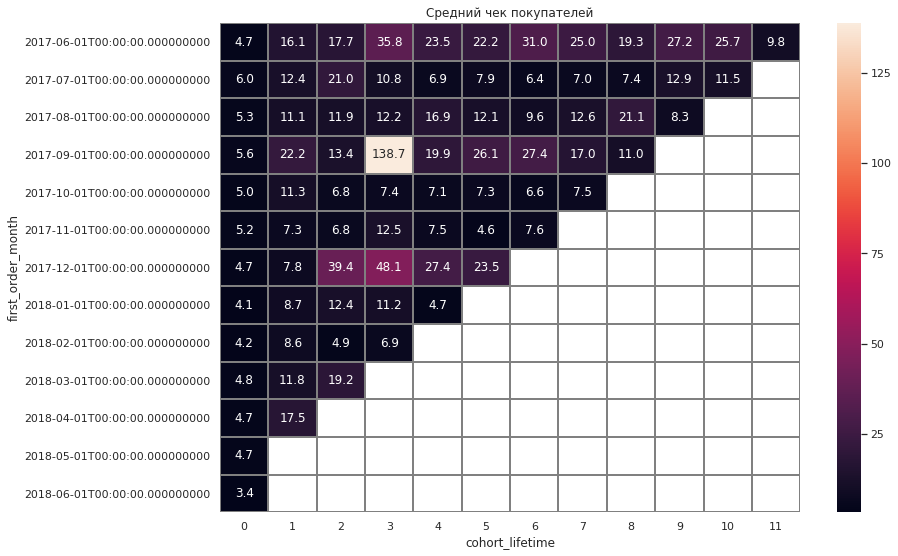

In [68]:
# тепловая карата
plt.figure(figsize=(13, 9))
plt.title('Средний чек покупателей')
sns.heatmap(revenue_per_user_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.show()

Средний чек когорты сентября 2017 очень сильно выделяется.

Также есть большие значения в декабре, но эти значения не выглядят так подозрительно, так как в начале на диаграмме с пользовательскими сессиями был пик в декабре.

#### Определения


LTV (от англ. lifetime value) — «пожизненная» ценность клиента. Это — итоговая сумма денег, которую один клиент приносит в среднем со всех своих покупок. При расчёте LTV обычно обращаются к валовой прибыли с клиента за период.

CAC (от англ. customer acquisition cost) — стоимость привлечения клиента. Сумма денег, во сколько обходится новый клиент компании. 

ROI (от англ. return on investment) или ROR (англ. rate of return) — финансовый коэффициент, иллюстрирующий уровень доходности или убыточности бизнеса, учитывая сумму сделанных в этот бизнес инвестиций.

#### Расчет LTV

In [69]:
# профиль пользователя
users=(visits.sort_values(by=['uid', 'start_ts']).groupby('uid').agg({'start_ts': 'first', 'source_id' :'first', 'device' :'first'}).rename(columns={'start_ts': 'acquisition_ts'}))
users['acquisition_date'] = users['acquisition_ts'].dt.date
users['acquisition_month'] = users['acquisition_ts'].astype('datetime64[M]')
costs.rename(columns={'dt': 'acquisition_date'}, inplace=True)

users=(users.reset_index().set_index(['source_id', 'acquisition_date']).join(costs.set_index(['source_id', 'acquisition_date']), how='left'))
users.head()

uid      acquisition_ts   device  \
source_id acquisition_date                                                     
1         2017-06-01         469568501030474895 2017-06-01 05:30:00  desktop   
          2017-06-01         618675438905551322 2017-06-01 02:37:00    touch   
          2017-06-01        1074355127080856382 2017-06-01 09:21:00  desktop   
          2017-06-01        1292867924428534308 2017-06-01 12:53:00  desktop   
          2017-06-01        1548840741623289234 2017-06-01 01:18:00  desktop   

                           acquisition_month  costs  
source_id acquisition_date                           
1         2017-06-01              2017-06-01   75.2  
          2017-06-01              2017-06-01   75.2  
          2017-06-01              2017-06-01   75.2  
          2017-06-01              2017-06-01   75.2  
          2017-06-01              2017-06-01   75.2

In [70]:
# стоимость приобретения индивидуального пользователя
user_cost=(users.groupby(['source_id', 'acquisition_date']).agg({'device': 'count', 'costs': 'max'}).rename(columns={'device':'users'}))
user_cost['acquisition_cost'] = user_cost['costs'] / user_cost['users']
users = users.join(user_cost[['acquisition_cost']], how='left')
users = users.reset_index().set_index('uid')[['acquisition_ts', 'acquisition_date', 'acquisition_month', 'source_id', 'device', 'acquisition_cost']]
users.head()

,acquisition_ts,acquisition_date,acquisition_month,source_id,device,acquisition_cost
uid,,,,,,
469568501030474895,2017-06-01 05:30:00,2017-06-01,2017-06-01,1,desktop,1.6
618675438905551322,2017-06-01 02:37:00,2017-06-01,2017-06-01,1,touch,1.6
1074355127080856382,2017-06-01 09:21:00,2017-06-01,2017-06-01,1,desktop,1.6
1292867924428534308,2017-06-01 12:53:00,2017-06-01,2017-06-01,1,desktop,1.6
1548840741623289234,2017-06-01 01:18:00,2017-06-01,2017-06-01,1,desktop,1.6


In [71]:
users1 = users.merge(orders, how='left', on='uid')
users1

,uid,acquisition_ts,acquisition_date,acquisition_month,source_id,device,acquisition_cost,buy_ts,revenue,first_order_date,first_order_month,order_month
0,469568501030474895,2017-06-01 05:30:00,2017-06-01,2017-06-01,1,desktop,1.600000,2017-09-11 00:06:00,3.05,2017-09-11 00:06:00,2017-09-01,2017-09-01
1,469568501030474895,2017-06-01 05:30:00,2017-06-01,2017-06-01,1,desktop,1.600000,2017-11-26 12:24:00,5.13,2017-09-11 00:06:00,2017-09-01,2017-11-01
2,469568501030474895,2017-06-01 05:30:00,2017-06-01,2017-06-01,1,desktop,1.600000,2017-11-29 14:07:00,19.74,2017-09-11 00:06:00,2017-09-01,2017-11-01
3,469568501030474895,2017-06-01 05:30:00,2017-06-01,2017-06-01,1,desktop,1.600000,2017-11-30 08:18:00,6.11,2017-09-11 00:06:00,2017-09-01,2017-11-01
4,469568501030474895,2017-06-01 05:30:00,2017-06-01,2017-06-01,1,desktop,1.600000,2017-12-06 14:00:00,2.44,2017-09-11 00:06:00,2017-09-01,2017-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...
242056,17550479715346067160,2018-05-31 22:00:00,2018-05-31,2018-05-01,10,touch,0.177778,NaT,NaN,NaT,NaT,NaT
242057,17715613363403416471,2018-05-31 03:30:00,2018-05-31,2018-05-01,10,desktop,0.177778,NaT,NaN,NaT,NaT,NaT
242058,18076428844159112818,2018-05-31 17:47:00,2018-05-31,2018-05-01,10,touch,0.177778,NaT,NaN,NaT,NaT,NaT
242059,18238279803055794091,2018-05-31 15:52:00,2018-05-31,2018-05-01,10,touch,0.177778,NaT,NaN,NaT,NaT,NaT


In [72]:
# выручка по когортам
cohorts = users1.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
cohorts

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58
...,...,...,...
74,2018-03-01,2018-05-01,1114.87
75,2018-04-01,2018-04-01,10600.69
76,2018-04-01,2018-05-01,1209.92
77,2018-05-01,2018-05-01,13925.76


In [73]:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
report.head()

,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


In [74]:
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

In [75]:
report['ltv'] = report['revenue'] / report['n_buyers']
    
output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').cumsum(axis=1).round(2)
    
output.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.5,7.66,7.78,7.92,8.08,8.23,8.39,
2017-08-01,5.28,5.75,6.21,6.6,7.09,7.38,7.59,7.99,8.28,8.47,,
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,,,
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.4,,,,,
2017-12-01,4.74,5,5.92,6.99,7.3,7.64,,,,,,
2018-01-01,4.14,4.43,4.73,4.88,4.94,,,,,,,
2018-02-01,4.16,4.44,4.51,4.59,,,,,,,,


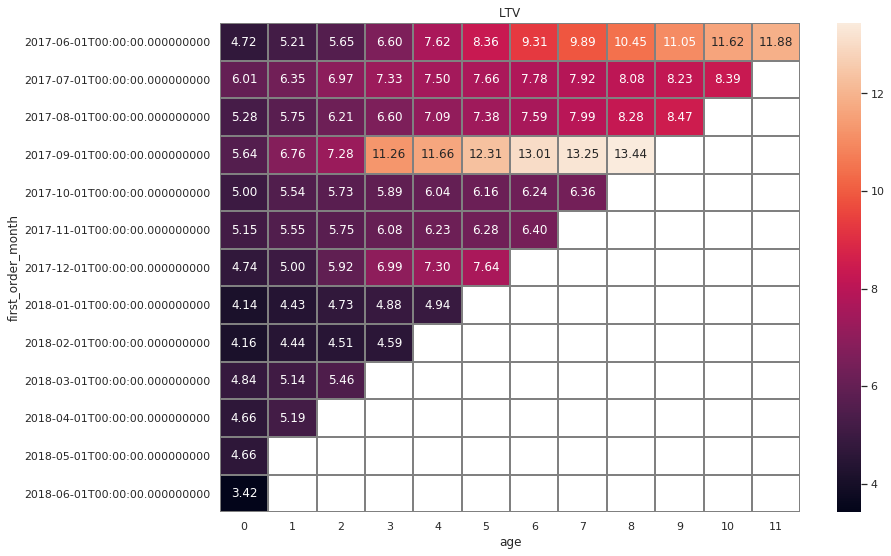

In [76]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('LTV')
sns.heatmap(output, annot=True, linewidths=1, linecolor='gray', fmt='.2f')
plt.show()

### Комментарий

In [77]:
coh1 = (users.groupby('device').agg({'source_id': 'count', 'acquisition_cost' :'sum'}).rename(columns={'source_id' :'cohort_size'})).reset_index()
coh1

,device,cohort_size,acquisition_cost
0,desktop,160795,235065.750929
1,touch,67374,94000.729071


In [78]:
ltv1 = orders.set_index('uid').join(users, how='left')[['acquisition_month', 'source_id', 'device', 'order_month', 'revenue']]
ltv1['age_month'] = (ltv1['order_month'] - ltv1['acquisition_month']) / np.timedelta64(1, 'M')
ltv1['age_month'] = ltv1['age_month'].round().astype('int')
ltv1 = ltv1.groupby(['device', 'age_month']).agg({'revenue':'sum'}).reset_index()


In [79]:
ltv1 = ltv1.merge(coh1, how='left', on='device')
ltv1.head()

,device,age_month,revenue,cohort_size,acquisition_cost
0,desktop,0,117165.49,160795,235065.750929
1,desktop,1,18442.39,160795,235065.750929
2,desktop,2,13011.79,160795,235065.750929
3,desktop,3,23398.22,160795,235065.750929
4,desktop,4,9767.11,160795,235065.750929


In [80]:
ltv1['ltv_device'] = ltv1['revenue'] / ltv1['cohort_size']

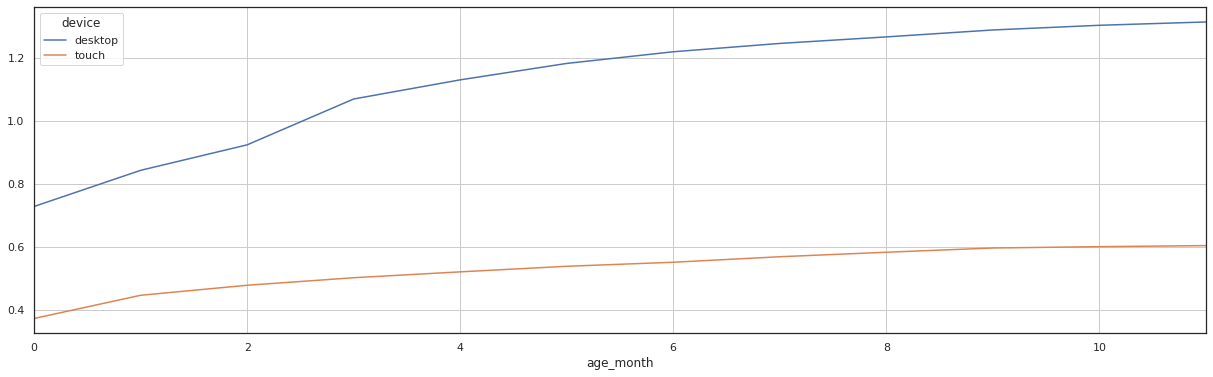

In [81]:
ltv1.pivot_table(index='age_month', columns='device', values='ltv_device').cumsum().plot(grid=True, figsize=(21, 6))
plt.show()

In [82]:
coh2 = (users.groupby('source_id').agg({'source_id': 'count', 'acquisition_cost' :'sum'}).rename(columns={'source_id' :'cohort_size'})).reset_index()
coh2

,source_id,cohort_size,acquisition_cost
0,1,9469,20833.27
1,2,17616,42806.04
2,3,66116,141321.63
3,4,72346,61073.60
4,5,49237,51756.40
5,6,2,0.00
6,7,32,0.00
7,9,6448,5454.42
8,10,6903,5821.12


In [83]:
ltv2 = orders.set_index('uid').join(users, how='left')[['acquisition_month', 'source_id', 'device', 'order_month', 'revenue']]
ltv2['age_month'] = (ltv2['order_month'] - ltv2['acquisition_month']) / np.timedelta64(1, 'M')
ltv2['age_month'] = ltv2['age_month'].round().astype('int')
ltv2 = ltv2.groupby(['source_id', 'age_month']).agg({'revenue':'sum'}).reset_index()
ltv2

,source_id,age_month,revenue
0,1,0,14526.97
1,1,1,2613.99
2,1,2,1795.52
3,1,3,2734.87
4,1,4,1691.99
...,...,...,...
80,10,7,25.97
81,10,8,4.28
82,10,9,17.69
83,10,10,7.82


In [84]:
ltv2 = ltv2.merge(coh2, how='left', on='source_id')
ltv2.head()

,source_id,age_month,revenue,cohort_size,acquisition_cost
0,1,0,14526.97,9469,20833.27
1,1,1,2613.99,9469,20833.27
2,1,2,1795.52,9469,20833.27
3,1,3,2734.87,9469,20833.27
4,1,4,1691.99,9469,20833.27


In [85]:
ltv2['ltv_source'] = ltv2['revenue'] / ltv2['cohort_size']

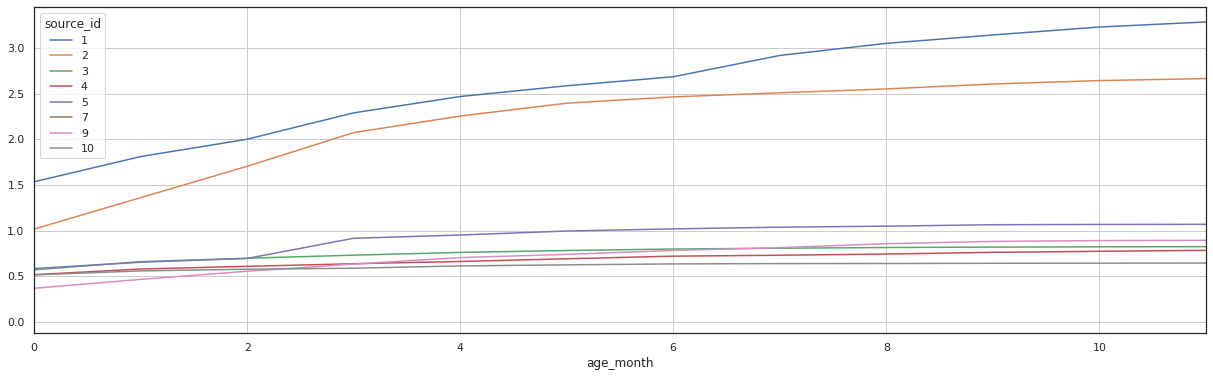

In [86]:
ltv2.pivot_table(index='age_month', columns='source_id', values='ltv_source').cumsum().plot(grid=True, figsize=(21, 6))
plt.show()

В итоге получилось, что 1 и 2 источники, а также desktop приносят больше денег. Надеюсь это правильно, во всяком случае, значения постепенно растут относительно номера месяца.

####  <span style="color: orange"> 2.3 Маркетинг <span>

#### Анализ затрат на рекламу

In [87]:
# всего затрат на рекламу
costs['costs'].sum()

329131.62

In [88]:
costs['costs_month'] = costs['acquisition_date'].astype('datetime64[M]')

In [89]:
# суммарные затраты по месяцам
costs.groupby('costs_month')['costs'].sum()

costs_month
2017-06-01    18015.00
2017-07-01    18240.59
2017-08-01    14790.54
2017-09-01    24368.91
2017-10-01    36322.88
2017-11-01    37907.88
2017-12-01    38315.35
2018-01-01    33518.52
2018-02-01    32723.03
2018-03-01    30415.27
2018-04-01    22289.38
2018-05-01    22224.27
Name: costs, dtype: float64

В сентябре и октябре резко выделили больше средств на рекламу и увеличивали это значение до декабря. Потом стали уменьшать затраты на рекламу.

In [90]:
# суммарные затраты по рекламным источникам
costs.groupby('source_id')['costs'].sum()

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

In [91]:
# сводная по источникам и месяцам
costs.pivot_table(index='costs_month', columns='source_id', values='costs', aggfunc='sum').style.highlight_max(axis='columns')

source_id,1,2,3,4,5,9,10
costs_month,,,,,,,
2017-06-01 00:00:00,1125.61,2427.38,7731.65,3514.8,2616.12,285.22,314.22
2017-07-01 00:00:00,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82
2017-08-01 00:00:00,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57
2017-09-01 00:00:00,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67
2017-10-01 00:00:00,2315.75,4845,15737.2,6420.84,5767.4,609.41,627.24
2017-11-01 00:00:00,2445.16,5247.68,17025.3,5388.82,6325.34,683.18,792.36
2017-12-01 00:00:00,2341.2,4897.8,16219.5,7680.47,5872.52,657.98,645.86
2018-01-01 00:00:00,2186.18,4157.74,14808.8,5832.79,5371.52,547.16,614.35
2018-02-01 00:00:00,2204.48,4474.34,14228.6,5711.96,5071.31,551.5,480.88


Из сводной таблицы видно, что каждый месяц в источник №3 направляется больше всего средств.

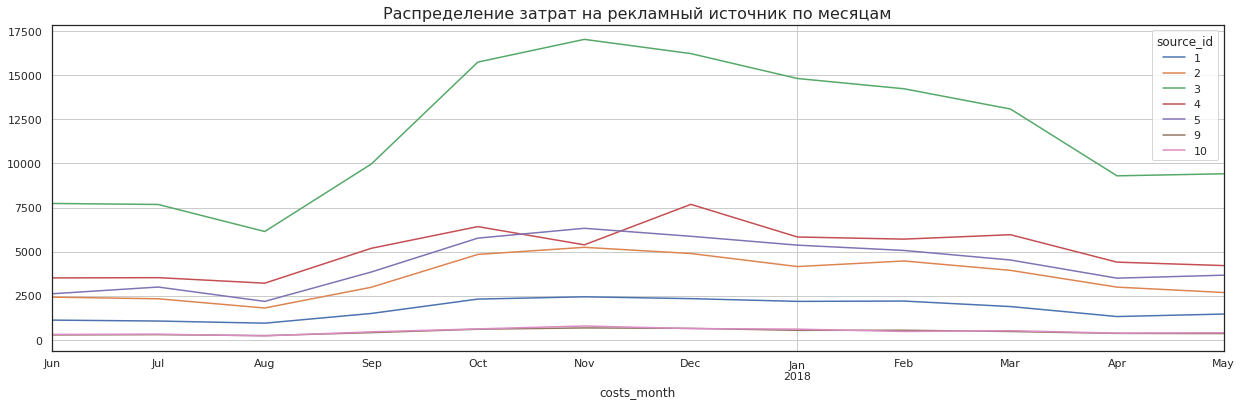

In [92]:
costs.pivot_table(index='costs_month', columns='source_id', values='costs', aggfunc='sum').plot(grid=True, figsize=(21, 6))
plt.title('Распределение затрат на рекламный источник по месяцам', fontsize=16)
plt.show()

Вывод: Для рекламного источника № 3 каждый месяц выделяется больше всего средств, тем не мнее, если посмотреть на диаграмму "количество сессий по датам по разным рекламным источникам" (в начале, пользователей, привлеченных из этого ресурса, не намного больше, чем из остальных. По количеству пользовательских сессий, источник №4 часто опережает №3. Можно порекомендовать пересмотреть распределение средств и выделить больше для №4.

#### Анализ стоимости покупателя

In [93]:
#  затраты по месяцам
monthly_costs = costs.groupby(['costs_month'])['costs'].sum()
monthly_costs=monthly_costs.to_frame().reset_index()

In [94]:
monthly_costs

,costs_month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


In [95]:
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='costs_month')

In [96]:
report_new

,first_order_month,n_buyers,order_month,revenue,age,ltv,costs_month,costs
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414,2017-06-01,18015.00
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329,2017-06-01,18015.00
2,2017-06-01,2023,2017-08-01,885.34,2,0.437637,2017-06-01,18015.00
3,2017-06-01,2023,2017-09-01,1931.30,3,0.954671,2017-06-01,18015.00
4,2017-06-01,2023,2017-10-01,2068.58,4,1.022531,2017-06-01,18015.00
...,...,...,...,...,...,...,...,...
73,2018-03-01,3533,2018-04-01,1063.05,1,0.300892,2018-03-01,30415.27
74,2018-03-01,3533,2018-05-01,1114.87,2,0.315559,2018-03-01,30415.27
75,2018-04-01,2276,2018-04-01,10600.69,0,4.657597,2018-04-01,22289.38
76,2018-04-01,2276,2018-05-01,1209.92,1,0.531599,2018-04-01,22289.38


In [108]:
ltv2.groupby('source_id')['revenue'].sum()

source_id
1     31090.55
2     46923.61
3     54511.24
4     56696.83
5     52624.02
7         1.22
9      5759.40
10     4450.33
Name: revenue, dtype: float64

In [97]:
# средняя стоимость привлечения клиента из источника
count_users = users1.groupby('source_id')['uid'].count().reset_index()
count_costs = costs.groupby('source_id')['costs'].sum().reset_index()
r = pd.merge(count_users, count_costs, how='left', on= 'source_id')
r['user_cost_source'] = r['costs'] / r['uid']
r

,source_id,uid,costs,user_cost_source
0,1,11793,20833.27,1.766579
1,2,20502,42806.04,2.087896
2,3,68932,141321.63,2.050160
3,4,74945,61073.60,0.814912
4,5,51712,51757.10,1.000872
5,6,2,NaN,NaN
6,7,32,NaN,NaN
7,9,7007,5517.49,0.787425
8,10,7136,5822.49,0.815932


Считаем CAC и ROMI

In [98]:
# стоимость привлечения клиента 
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new['romi'] = report_new['ltv'] / report_new['cac']

Мы соединяли визитс и ордерс, для каждого купившего пользователя брали первый источник посещения, группировали пользователей по этим источникам. Добавляли сгруппированные по источникам затраты.

Тут график: месяц и средняя стоимость привлечения клиента из источника в этот месяц.

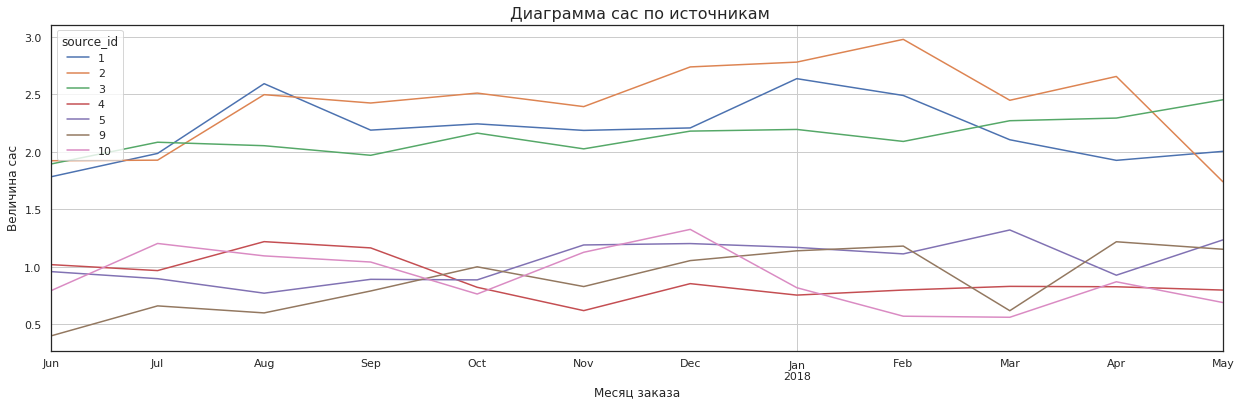

In [99]:
users.pivot_table(index='acquisition_month', columns='source_id', values='acquisition_cost').plot(grid=True, figsize=(21, 6))

plt.title(' Диаграмма cac по источникам', fontsize=16) 
plt.xlabel("Месяц заказа")
plt.ylabel("Величина cac")

plt.show()

In [100]:
# сводная таблица по месяцам, времени жизни когорты и окупаемости клиентов
output = report_new.pivot_table(
    index='first_order_month', 
    columns='age', 
    values='romi', 
    aggfunc='mean').cumsum(axis=1).round(2)
output.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.7,0.74,0.77,0.78,,
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.3,1.38,1.4,1.42,,,
2017-10-01,0.60,0.66,0.68,0.7,0.72,0.74,0.75,0.76,,,,
2017-11-01,0.55,0.6,0.62,0.65,0.67,0.68,0.69,,,,,
2017-12-01,0.54,0.57,0.68,0.8,0.84,0.87,,,,,,
2018-01-01,0.42,0.45,0.48,0.49,0.5,,,,,,,
2018-02-01,0.46,0.49,0.5,0.51,,,,,,,,


In [101]:
output.mean(axis=0)

age
0     0.540833
1     0.582727
2     0.629000
3     0.717778
4     0.783750
5     0.860000
6     0.898333
7     0.970000
8     1.052500
9     0.963333
10    1.095000
11    1.330000
dtype: float64

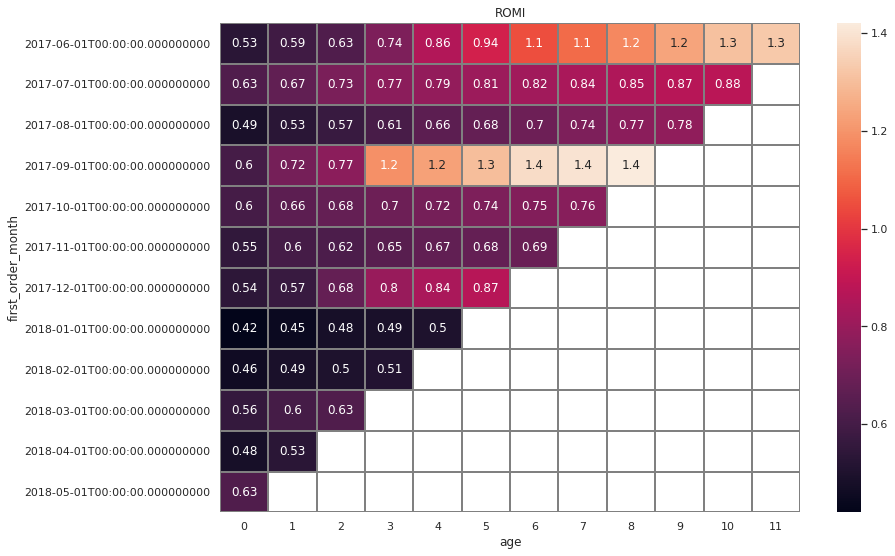

In [102]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('ROMI')
sns.heatmap(output, annot=True, linewidths=1, linecolor='gray')
plt.show()

Быстрее всего окупилась сентябрьская когорта, на 4 месяце; в целом все когорты окупаются ближе к 9 месяцу.

<span style="color: purple"> Тут я считаю romi исходя из ранее рассчитанных таблиц с ltv.

In [103]:
ltv1['cac'] = ltv1['acquisition_cost'] / ltv1['cohort_size']
ltv1['romi'] = ltv1['ltv_device'] / ltv1['cac']

In [104]:
ltv2['cac'] = ltv2['acquisition_cost'] / ltv2['cohort_size']
ltv2['romi'] = ltv2['ltv_source'] / ltv2['cac']

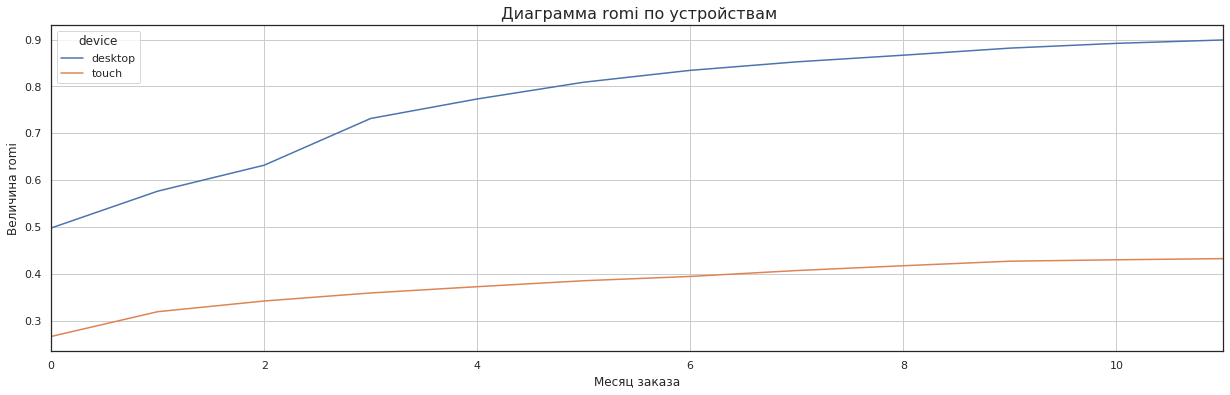

In [105]:
ltv1.pivot_table(index='age_month', columns='device', values='romi').cumsum().plot(grid=True, figsize=(21, 6))
plt.title(' Диаграмма romi по устройствам', fontsize=16) 
plt.xlabel("Месяц заказа")
plt.ylabel("Величина romi")

plt.show()

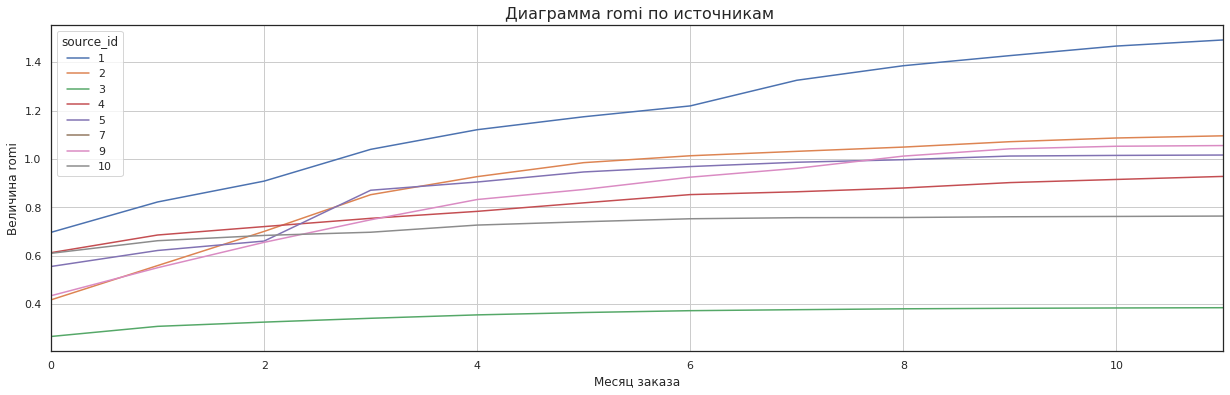

In [106]:
ltv2.pivot_table(index='age_month', columns='source_id', values='romi', aggfunc='mean').cumsum().plot(grid=True, figsize=(21, 6))

plt.title(' Диаграмма romi по источникам', fontsize=16) 
plt.xlabel("Месяц заказа")
plt.ylabel("Величина romi")

plt.show()

In [107]:
# ltv средней когорты
final_result = report_new.pivot_table( index='first_order_month', columns='age', values='ltv', aggfunc='mean')

m6_cum_ltv = final_result.cumsum(axis=1).mean(axis=0)[5]
m6_cum_ltv

7.969052630207331

### <span style="color:blue"> Шаг 3: Выводы и рекомендации <span>

1) Продукт
    - пользуются продуктом довольно часто: в месяц - 23228 пользователей, в неделю 5716, в день - 907;
    - в среднем на каждого зашедшего на сайт пользователя в день приходится один сеанс;
    - медианные значения длительности сессий : desktop- 6 минут, touch - 3 минуты, однако есть большое количество очень коротких сессий, возможно какие то неполадки, необходимо проверить;
    - возвращаются пользователи не очень часто.
    
2) Продажи
    - пользователи делают заказа с desktop через 11 минут после начала сессии, с touch - 14 минут;
    - всего летом 2017 совершалось около 2000 покупок в месяц, осенью возрасло до 4000-5000, после нового года начало снижаться;
    - средний чек меняется в зависимости от времени, растет ближе к новому году. Средний чек когорты сентября 2017 очень сильно выделяется;
    - ltv пользователей desktop выше, чем touch.
    
3) Маркетинг
    - всего потратили на рекламу : 329131.62 у.е., В сентябре и октябре резко выделили больше средств на рекламу и увеличивали это значение до декабря. Потом стали уменьшать затраты на рекламу;
    - в целом все когорты окупаются к 9 месяцу и бизнес не выглядит убыточным;
    - на привлечение одного покупателя, чтобы реклама окупилась за 6 месяцев, необходимо тратить не более 7.96 у.е.
    
Рекомендация маркетологам: пересмотреть вложения в рекламные источники. Т.к. источник №1 окупается быстрее других.
    